In [1]:
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import multiprocessing
import os
import random
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder



torch.__version__


'2.4.1'

### Function: `set_seed`

The `set_seed` function standardizes the randomness across Python’s `random`, NumPy, and PyTorch libraries to ensure consistent results on each run, which is crucial for reproducible experiments in machine learning. By setting a fixed seed for each library, including additional measures for CUDA if available, this function minimizes variability across experiments, helping in debugging and ensuring reproducibility.

In [2]:


def set_seed(seed_value=42):
    """
    Sets seed for reproducibility across various libraries and ensures deterministic behavior.

    Args:
        seed_value (int): The seed value to use for random number generators.
    """
    # Set seed for Python's built-in random module
    random.seed(seed_value)
    
    # Set seed for NumPy
    np.random.seed(seed_value)
    
    # Set seed for PyTorch
    torch.manual_seed(seed_value)
    
    # If you're using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # If you're using multiple GPUs

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Set paths to train , test and validation directories

In [4]:
# Paths to the train, validation, and test directories
train_dir = '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test'
val_dir = '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/val'
test_dir = '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test'

Below i have first defined `walk_through_dir`, a function that counts the number of images in each subdirectory within a specified directory path. This function is useful for loading and inspecting dataset contents in a directory structure organized by classes.


**Usage**:
- `walk_through_dir` is called on training, validation, and test directories to count images.



In [5]:

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents and plotting the number of images in each subdirectory.

    Args:
      dir_path (str or pathlib.Path): target directory
    """
    class_names = []
    num_images = []

    for dirpath, dirnames, filenames in os.walk(dir_path):
        # Skip the root folder
        if len(dirnames) == 0:  # If there are no more subdirectories
            class_name = os.path.basename(dirpath)  # Get class name (subdirectory)
            class_names.append(class_name)
            num_images.append(len(filenames))  # Append number of files (images)

            print(f"There are {len(filenames)} images in '{dirpath}'.")

    return class_names, num_images



# Get the number of images per class in each directory
train_classes, train_images = walk_through_dir(train_dir)
val_classes, val_images = walk_through_dir(val_dir)
test_classes, test_images = walk_through_dir(test_dir)




There are 100 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test/Non Mask'.
There are 100 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test/Mask'.
There are 306 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/val/Non Mask'.
There are 306 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/val/Mask'.
There are 100 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test/Non Mask'.
There are 100 images in '/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test/Mask'.


### Define Model

In this code, I start by loading a pre-trained MobileNetV3 Large model to leverage its existing feature extraction capabilities. I then freeze all the layers except the final classifier layer to retain the learned weights while allowing customization. I modify the classifier layer to output a single logit, making it suitable for binary classification.

Next, I ensure that only the classifier layer’s parameters will be updated during training by setting `requires_grad` to `True` for this layer alone. Finally, I move the model to the specified device (GPU or CPU) to optimize training and inference.

In [6]:
# Load MobileNetV3_Large with default pre-trained weights
weights = models.MobileNet_V3_Large_Weights.DEFAULT
model = models.mobilenet_v3_large(weights=weights)

# Freeze all the layers except the final classifier layer
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to output 1 logit for binary classification
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)

# Ensure that the classifier layer's parameters will be updated during training
for param in model.classifier[3].parameters():
    param.requires_grad = True

# Move the model to the specified device (GPU or CPU)
model = model.to(device)



In [7]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(64,3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [64, 3, 224, 224]    [64, 1]              --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [64, 16, 112, 112]   [64, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [64, 16, 112, 112]   [64, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [64, 16, 112, 112]   [64, 

### Tranforms 

lets define the transformation pipeline for MobileNetV3, following the model’s input requirements. First, I resize the images to 224x224 pixels, which matches the expected input size for MobileNet. Next, I convert the images to PyTorch tensors and apply normalization using the mean and standard deviation values recommended by the model's pre-trained weights. This normalization ensures consistency with how the model was originally trained.


In [8]:
# Define the transformation pipeline for MobileNetV3
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

### Datasets creation
Its time to create datasets for training, validation, and testing using the transformation pipeline I defined earlier. I use `ImageFolder`, which allows me to load images from directories organized by class labels. Each dataset (`train_dataset`, `val_dataset`, and `test_dataset`) is assigned a specific directory and will apply the transformations during loading, ensuring that all images are resized, converted to tensors, and normalized consistently across the datasets.


In [9]:
# Datasets using these transforms
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [10]:
train_dataset,val_dataset,test_dataset

(Dataset ImageFolder
     Number of datapoints: 100
     Root location: /home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 306
     Root location: /home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 100
     Root location: /home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/dataset/test
     StandardTransform
 

### Class name 
Lets get class name from dataset so latter on we can use them for visualization

In [11]:
class_names = train_dataset.classes
class_names

['Mask', 'Non Mask']

we can get class to index mapping from dataset

In [12]:
train_dataset.class_to_idx

{'Mask': 0, 'Non Mask': 1}

### Lets avaliable cpu counts so we can optimize dataloader 

This count will be different for different computers and will depend on the specific hardware setup.

In [13]:
os.cpu_count()

16

### Dataloader

Lets set up optimized `DataLoader` configurations to efficiently load data for training, validation, and testing. I calculate `num_workers` based on the available CPU cores, which helps accelerate data loading. I set the `batch_size` to 64 for manageable memory usage during training (please adjust this number based on your computer capicity).

- **Train Loader**: I enable shuffling to randomize the data for each epoch, used `pin_memory` for faster data transfer to the GPU, and set `prefetch_factor` to 4 for faster loading of future batches.
- **Validation and Test Loaders**: For these loaders, I disable shuffling since order doesn’t affect evaluation. Like the train loader, I enable `pin_memory` and optimize it with multiple workers for efficiency.

These settings aim to improve data loading speed and ensure smoother, faster model training and evaluation.


In [14]:
#  Optimized DataLoader settings
num_workers = multiprocessing.cpu_count() # Use half of available CPU cores
batch_size= 64

# Create DataLoaders with optimal settings
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,  # Use multiple workers for data loading
    pin_memory=True,  # Use pinned memory for faster GPU transfer
    prefetch_factor= 4,  # Prefetch batches for efficiency
    shuffle=True, 
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation set
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test set
    num_workers=num_workers,
    pin_memory=True
)

In [15]:
train_loader,val_loader,test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f00eb35fd70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f00eb35f980>)

### Data visulazation using matplotlib

Lets visualize the some example images from the training, validation, and testing sets to get a sense of the dataset. I use a simple function to display the images with their corresponding class labels.

In [16]:


# Function to visualize a batch of images with labels
def show_images(loader):

    # Get a batch of images and labels from the DataLoader
    images, labels = next(iter(loader))
    
    # Set up the figure
    plt.figure(figsize=(10, 10))
    
    # Loop through and display the first 9 images
    for i in range(30):
        ax = plt.subplot(10, 3, i + 1)
        
        # Convert the image to HWC format for matplotlib and unnormalize the image
        img = images[i].numpy().transpose((1, 2, 0))  # Convert from CHW to HWC format
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)  # Unnormalize
        plt.imshow(img)
        plt.title(loader.dataset.classes[labels[i]], fontsize=9)  # Display the class name
        plt.axis("off")  # Turn off the axis for clarity
    
    # Show the plot
    plt.show()




Train Images


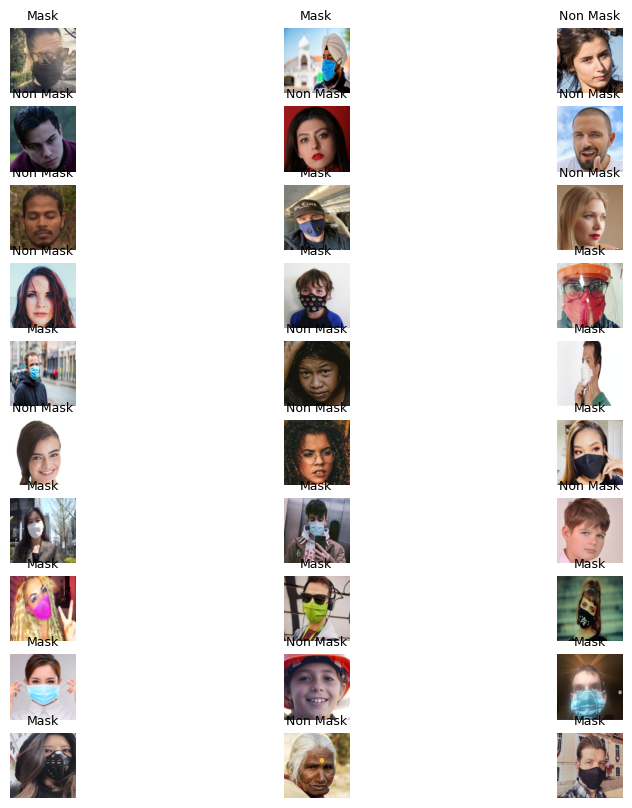

Validation Images


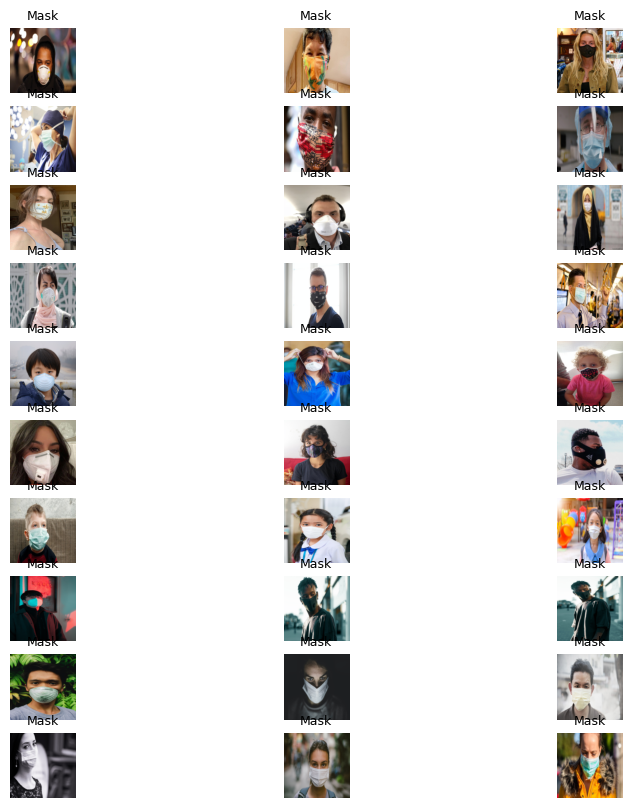

Test Images


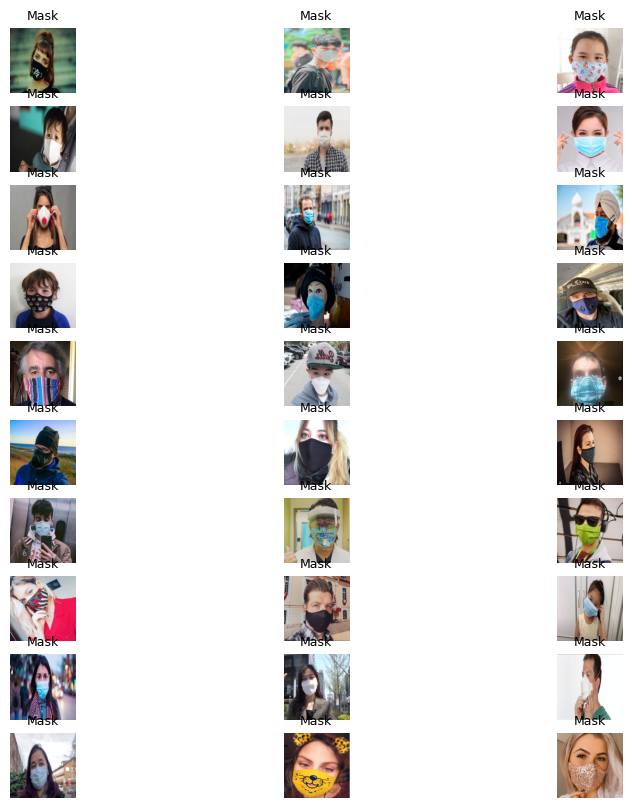

In [17]:

# Visualize some images from the train, validation, and test sets
print("Train Images")
show_images(train_loader)
print("Validation Images")
show_images(val_loader)
print("Test Images")
show_images(test_loader)

### Define criterion and optimizer

Lets now define the loss function and optimizer for training the model.

1. **Loss Function**: I used `nn.BCEWithLogitsLoss()`, which is well-suited for binary classification tasks. This function combines a sigmoid layer and binary cross-entropy loss, making it ideal for models that output raw logits.

2. **Optimizer**: I chose the Adam optimizer (`optim.Adam`) for its adaptive learning capabilities and set a learning rate of `0.0001`. I pass `model.parameters()` to ensure that only the trainable parameters (unfrozen layers) will be updated during backpropagation.

Right now i am not using the learning rate scheduler as learning rate is very low for this model. You may want to adjust the learning rate as needed.

In [18]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training , validation and Visualization

In this code, I define `train_model`, a function to train and evaluate my model, with checkpointing to save the best model based on validation accuracy.

1. **Set Up Tracking**: I initialize lists to track training and validation losses and accuracies, and a variable to store the best validation accuracy.

2. **Training Loop**: For each epoch, I iterate over the training data:
   - I move inputs and labels to the appropriate device, set up for binary classification, and compute the loss using `BCEWithLogitsLoss`.
   - I then backpropagate the loss and update the model’s weights with `optimizer.step()`, accumulating loss and accuracy.

3. **Validation Loop**: After training, I evaluate the model on the validation set:
   - Using `torch.no_grad()` to prevent gradient calculations, I calculate the validation loss and accuracy.
   - If the current validation accuracy is the best so far, I save the model’s state.

4. **Plotting Results**: After all epochs, I plot the training and validation loss and accuracy curves, allowing me to visualize performance over time.

This function returns the trained model, ready for further evaluation.


In [19]:

# Function to plot losses and accuracies
def plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))  # Generate epoch numbers

    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    #plt.xticks(epochs)  # Set x-ticks to match the number of epochs
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    #plt.xticks(epochs)  # Set x-ticks to match the number of epochs
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')




In [20]:

# Function to train and evaluate the model with checkpointing for best validation accuracy
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, save_dir="/home/arsalan/pytorch/transfer_learning/face_mask_mobilenet_large/artifacts"):
    model.train()  # Set the model to training mode

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0  # Variable to store the best validation accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        model.train()  # Ensure the model is in training mode
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float for BCEWithLogitsLoss
            labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]
            
            optimizer.zero_grad()

            # Forward pass - extract only logits if present
            outputs = model(inputs)
            if isinstance(outputs, torch.Tensor):
                logits = outputs
            else:
                logits = outputs.logits

            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)

            # For BCEWithLogitsLoss, logits > 0 are predicted as class 1, otherwise class 0
            predicted = (logits > 0.0).float()  # Convert logits to predictions (0 or 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Detach loss and accuracy from the graph
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float for BCEWithLogitsLoss
                labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

                outputs = model(inputs)
                if isinstance(outputs, torch.Tensor):
                    logits = outputs
                else:
                    logits = outputs.logits

                loss = criterion(logits, labels)

                # Accumulate validation loss
                val_loss += loss.item() * inputs.size(0)

                # Validation accuracy
                predicted = (logits > 0.0).float()  # Convert logits to predictions (0 or 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Detach validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Save the best model checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"Saving new best model with validation accuracy: {val_acc:.4f}")
            # Construct the filename with the validation accuracy
            checkpoint_path = f"{save_dir}/train_loss{epoch_loss:.4f}_train_acc{epoch_acc:.4f}_val_loss{val_loss:.4f}_val_acc_{best_val_acc:.4f}.pth"
            torch.save(model.state_dict(), checkpoint_path)  # Save the model's state dict

        # Append detached values to lists for plotting
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Return metrics along with the model for future use
    return model, train_losses, train_accuracies, val_losses, val_accuracies, num_epochs


### Train the model for a few epochs

Epoch 1/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Saving new best model with validation accuracy: 0.7255
Epoch [1/30], Loss: 0.6879, Accuracy: 0.5700, Validation Loss: 0.6477, Validation Accuracy: 0.7255


Epoch 2/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Saving new best model with validation accuracy: 0.7451
Epoch [2/30], Loss: 0.6794, Accuracy: 0.6000, Validation Loss: 0.6461, Validation Accuracy: 0.7451


Epoch 3/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Saving new best model with validation accuracy: 0.7516
Epoch [3/30], Loss: 0.6696, Accuracy: 0.6500, Validation Loss: 0.6444, Validation Accuracy: 0.7516


Epoch 4/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Saving new best model with validation accuracy: 0.7582
Epoch [4/30], Loss: 0.6642, Accuracy: 0.7200, Validation Loss: 0.6427, Validation Accuracy: 0.7582


Epoch 5/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Saving new best model with validation accuracy: 0.7778
Epoch [5/30], Loss: 0.6588, Accuracy: 0.6500, Validation Loss: 0.6408, Validation Accuracy: 0.7778


Epoch 6/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [6/30], Loss: 0.6615, Accuracy: 0.6500, Validation Loss: 0.6390, Validation Accuracy: 0.7778


Epoch 7/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Saving new best model with validation accuracy: 0.7941
Epoch [7/30], Loss: 0.6524, Accuracy: 0.7100, Validation Loss: 0.6371, Validation Accuracy: 0.7941


Epoch 8/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Saving new best model with validation accuracy: 0.8039
Epoch [8/30], Loss: 0.6476, Accuracy: 0.7200, Validation Loss: 0.6353, Validation Accuracy: 0.8039


Epoch 9/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Saving new best model with validation accuracy: 0.8072
Epoch [9/30], Loss: 0.6491, Accuracy: 0.7500, Validation Loss: 0.6334, Validation Accuracy: 0.8072


Epoch 10/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch [10/30], Loss: 0.6373, Accuracy: 0.7600, Validation Loss: 0.6315, Validation Accuracy: 0.8072


Epoch 11/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Saving new best model with validation accuracy: 0.8105
Epoch [11/30], Loss: 0.6451, Accuracy: 0.7000, Validation Loss: 0.6296, Validation Accuracy: 0.8105


Epoch 12/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Saving new best model with validation accuracy: 0.8268
Epoch [12/30], Loss: 0.6358, Accuracy: 0.7900, Validation Loss: 0.6276, Validation Accuracy: 0.8268


Epoch 13/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Saving new best model with validation accuracy: 0.8301
Epoch [13/30], Loss: 0.6284, Accuracy: 0.7800, Validation Loss: 0.6255, Validation Accuracy: 0.8301


Epoch 14/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch [14/30], Loss: 0.6274, Accuracy: 0.8200, Validation Loss: 0.6234, Validation Accuracy: 0.8268


Epoch 15/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [15/30], Loss: 0.6166, Accuracy: 0.8000, Validation Loss: 0.6213, Validation Accuracy: 0.8301


Epoch 16/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Saving new best model with validation accuracy: 0.8333
Epoch [16/30], Loss: 0.6181, Accuracy: 0.8100, Validation Loss: 0.6192, Validation Accuracy: 0.8333


Epoch 17/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Saving new best model with validation accuracy: 0.8366
Epoch [17/30], Loss: 0.6064, Accuracy: 0.8500, Validation Loss: 0.6171, Validation Accuracy: 0.8366


Epoch 18/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Saving new best model with validation accuracy: 0.8431
Epoch [18/30], Loss: 0.6072, Accuracy: 0.8500, Validation Loss: 0.6149, Validation Accuracy: 0.8431


Epoch 19/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Saving new best model with validation accuracy: 0.8497
Epoch [19/30], Loss: 0.6045, Accuracy: 0.8600, Validation Loss: 0.6127, Validation Accuracy: 0.8497


Epoch 20/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [20/30], Loss: 0.5934, Accuracy: 0.9000, Validation Loss: 0.6105, Validation Accuracy: 0.8497


Epoch 21/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Saving new best model with validation accuracy: 0.8595
Epoch [21/30], Loss: 0.6015, Accuracy: 0.8400, Validation Loss: 0.6083, Validation Accuracy: 0.8595


Epoch 22/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch [22/30], Loss: 0.5872, Accuracy: 0.8700, Validation Loss: 0.6060, Validation Accuracy: 0.8595


Epoch 23/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [23/30], Loss: 0.5902, Accuracy: 0.8400, Validation Loss: 0.6038, Validation Accuracy: 0.8595


Epoch 24/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Saving new best model with validation accuracy: 0.8627
Epoch [24/30], Loss: 0.5830, Accuracy: 0.9100, Validation Loss: 0.6014, Validation Accuracy: 0.8627


Epoch 25/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Saving new best model with validation accuracy: 0.8660
Epoch [25/30], Loss: 0.5783, Accuracy: 0.8700, Validation Loss: 0.5990, Validation Accuracy: 0.8660


Epoch 26/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [26/30], Loss: 0.5729, Accuracy: 0.9100, Validation Loss: 0.5966, Validation Accuracy: 0.8627


Epoch 27/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [27/30], Loss: 0.5738, Accuracy: 0.8800, Validation Loss: 0.5942, Validation Accuracy: 0.8627


Epoch 28/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [28/30], Loss: 0.5634, Accuracy: 0.9200, Validation Loss: 0.5918, Validation Accuracy: 0.8660


Epoch 29/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Saving new best model with validation accuracy: 0.8693
Epoch [29/30], Loss: 0.5585, Accuracy: 0.9200, Validation Loss: 0.5893, Validation Accuracy: 0.8693


Epoch 30/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [30/30], Loss: 0.5648, Accuracy: 0.9300, Validation Loss: 0.5868, Validation Accuracy: 0.8693


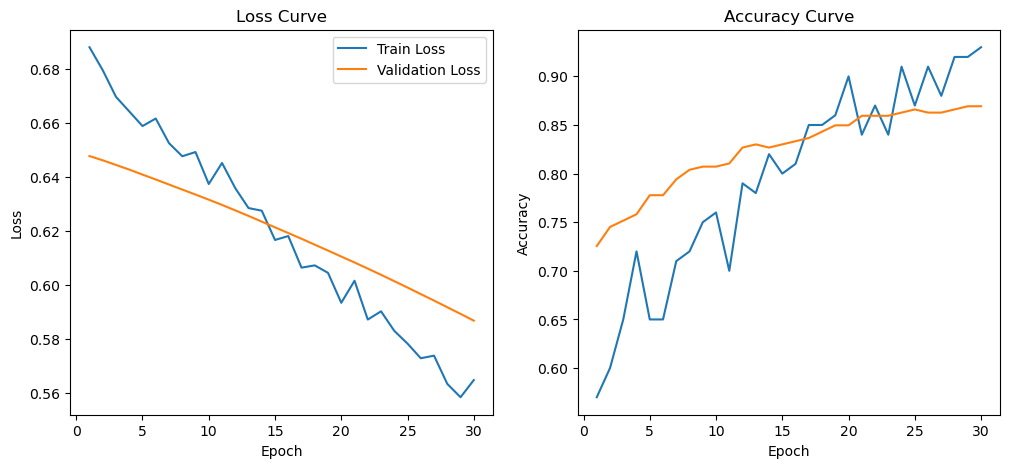

In [21]:
# Initial training
model, train_losses, train_accuracies, val_losses, val_accuracies, epochs = train_model(model, criterion, optimizer, 
                                                                                        train_loader, 
                                                                                        val_loader,num_epochs = 30)

# Plot after initial training
plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)




As we can see ,  our model is trained for 30 epochs and we see that the validation accuracy increases with each epoch.Also train loss and validation loss decrease. This shows that our model is learning and improving over time.We should train the model for a few more epochs to achieve better results.Lets train the model for 30 more epochs to get a better model.

Epoch 1/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Saving new best model with validation accuracy: 0.8693
Epoch [1/30], Loss: 0.5525, Accuracy: 0.9200, Validation Loss: 0.5842, Validation Accuracy: 0.8693


Epoch 2/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Saving new best model with validation accuracy: 0.8758
Epoch [2/30], Loss: 0.5550, Accuracy: 0.9300, Validation Loss: 0.5817, Validation Accuracy: 0.8758


Epoch 3/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Saving new best model with validation accuracy: 0.8791
Epoch [3/30], Loss: 0.5468, Accuracy: 0.9400, Validation Loss: 0.5791, Validation Accuracy: 0.8791


Epoch 4/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Saving new best model with validation accuracy: 0.8824
Epoch [4/30], Loss: 0.5547, Accuracy: 0.9200, Validation Loss: 0.5765, Validation Accuracy: 0.8824


Epoch 5/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch [5/30], Loss: 0.5492, Accuracy: 0.9500, Validation Loss: 0.5740, Validation Accuracy: 0.8824


Epoch 6/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Saving new best model with validation accuracy: 0.8856
Epoch [6/30], Loss: 0.5380, Accuracy: 0.9500, Validation Loss: 0.5715, Validation Accuracy: 0.8856


Epoch 7/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [7/30], Loss: 0.5462, Accuracy: 0.9400, Validation Loss: 0.5689, Validation Accuracy: 0.8856


Epoch 8/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [8/30], Loss: 0.5291, Accuracy: 0.9800, Validation Loss: 0.5664, Validation Accuracy: 0.8856


Epoch 9/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch [9/30], Loss: 0.5240, Accuracy: 0.9400, Validation Loss: 0.5638, Validation Accuracy: 0.8856


Epoch 10/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Saving new best model with validation accuracy: 0.8889
Epoch [10/30], Loss: 0.5264, Accuracy: 0.9600, Validation Loss: 0.5612, Validation Accuracy: 0.8889


Epoch 11/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Saving new best model with validation accuracy: 0.8954
Epoch [11/30], Loss: 0.5222, Accuracy: 0.9800, Validation Loss: 0.5585, Validation Accuracy: 0.8954


Epoch 12/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Saving new best model with validation accuracy: 0.8987
Epoch [12/30], Loss: 0.5261, Accuracy: 0.9500, Validation Loss: 0.5559, Validation Accuracy: 0.8987


Epoch 13/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch [13/30], Loss: 0.5154, Accuracy: 0.9900, Validation Loss: 0.5534, Validation Accuracy: 0.8987


Epoch 14/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch [14/30], Loss: 0.5161, Accuracy: 0.9500, Validation Loss: 0.5508, Validation Accuracy: 0.8987


Epoch 15/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [15/30], Loss: 0.5063, Accuracy: 0.9700, Validation Loss: 0.5482, Validation Accuracy: 0.8987


Epoch 16/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [16/30], Loss: 0.5062, Accuracy: 0.9300, Validation Loss: 0.5456, Validation Accuracy: 0.8987


Epoch 17/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Saving new best model with validation accuracy: 0.9020
Epoch [17/30], Loss: 0.5013, Accuracy: 0.9400, Validation Loss: 0.5430, Validation Accuracy: 0.9020


Epoch 18/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [18/30], Loss: 0.4999, Accuracy: 0.9500, Validation Loss: 0.5404, Validation Accuracy: 0.8987


Epoch 19/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch [19/30], Loss: 0.4910, Accuracy: 0.9800, Validation Loss: 0.5378, Validation Accuracy: 0.9020


Epoch 20/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Saving new best model with validation accuracy: 0.9118
Epoch [20/30], Loss: 0.4941, Accuracy: 0.9600, Validation Loss: 0.5352, Validation Accuracy: 0.9118


Epoch 21/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch [21/30], Loss: 0.4862, Accuracy: 0.9700, Validation Loss: 0.5327, Validation Accuracy: 0.9118


Epoch 22/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Saving new best model with validation accuracy: 0.9150
Epoch [22/30], Loss: 0.4859, Accuracy: 0.9800, Validation Loss: 0.5301, Validation Accuracy: 0.9150


Epoch 23/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [23/30], Loss: 0.4876, Accuracy: 0.9700, Validation Loss: 0.5276, Validation Accuracy: 0.9150


Epoch 24/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch [24/30], Loss: 0.4782, Accuracy: 0.9900, Validation Loss: 0.5251, Validation Accuracy: 0.9150


Epoch 25/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch [25/30], Loss: 0.4776, Accuracy: 0.9800, Validation Loss: 0.5226, Validation Accuracy: 0.9150


Epoch 26/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch [26/30], Loss: 0.4735, Accuracy: 0.9800, Validation Loss: 0.5202, Validation Accuracy: 0.9150


Epoch 27/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [27/30], Loss: 0.4731, Accuracy: 0.9800, Validation Loss: 0.5176, Validation Accuracy: 0.9118


Epoch 28/30 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch [28/30], Loss: 0.4689, Accuracy: 0.9800, Validation Loss: 0.5152, Validation Accuracy: 0.9118


Epoch 29/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [29/30], Loss: 0.4673, Accuracy: 0.9800, Validation Loss: 0.5128, Validation Accuracy: 0.9118


Epoch 30/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [30/30], Loss: 0.4685, Accuracy: 0.9700, Validation Loss: 0.5104, Validation Accuracy: 0.9150


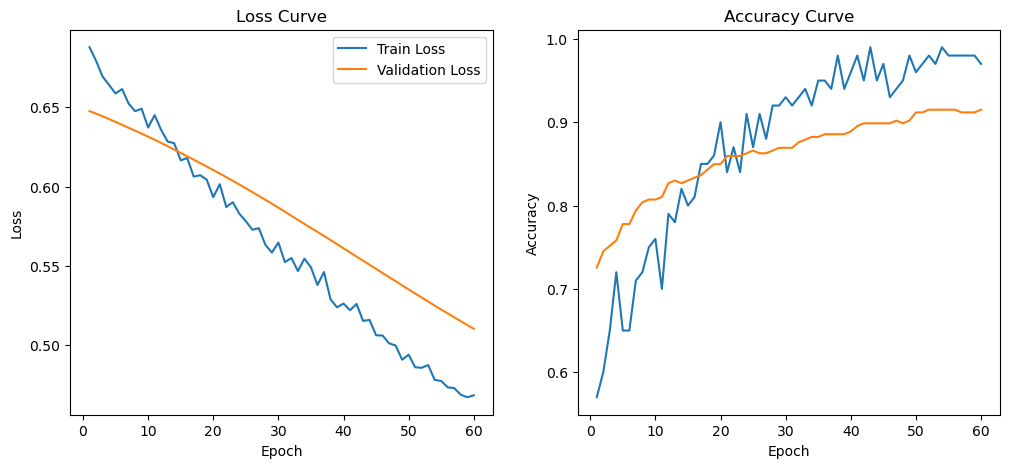

In [22]:
model, train_loss, train_acc, val_loss, val_acc, epochs = train_model(model, criterion, optimizer, 
                                                                      train_loader, val_loader,
                                                                      num_epochs= 30)
# Append metrics to the tracking lists
train_losses.extend(train_loss)
val_losses.extend(val_loss)
train_accuracies.extend(train_acc)
val_accuracies.extend(val_acc)
# Plot after initial training
plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

Although train loss and validation loss decreased little bit more but still validation accuracy dint increase much . On the other hand training accuracy has almost reached 99% . if we train this model further more , chances to get good validation accuracy are less . Lets try to unfreez some layers of our mobile net model and see if we can get some better results.
Here is the explaination of code written below for to unfreeze some layers of MobileNetV3:

1. **Unfreeze Last Layers**: I selectively unfreeze parameters in the deeper layers (`features[12:]`), as these layers capture high-level features that can benefit from fine-tuning for my specific dataset. I also ensure that the classifier layer remains trainable.

2. **Reinitialize Optimizer**: After unfreezing, I reinitialize the optimizer to include only the parameters with `requires_grad=True`. I set a smaller learning rate (`1e-5`) for these layers to ensure stable fine-tuning without over-adjusting the pre-trained weights.

3. **Continue Training**: Finally, I call `train_model` with the updated model and optimizer, setting the number of epochs to 20 for fine-tuning.



In [23]:

# We'll unfreeze 'layer3' and 'layer4' (example layers) in the MobileNetV3_Large architecture

# Unfreeze the parameters of the last two blocks of the network (deep layers)
for param in model.features[12:].parameters():  # 'features[12:]' represents the deeper layers in MobileNetV3
    param.requires_grad = True

# The classifier remains trainable as before
for param in model.classifier.parameters():
    param.requires_grad = True

# Reinitialize the optimizer to include parameters of newly unfrozen layers
# Use a smaller learning rate for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)


### Very important things to know about loss and accuracy here:

The `train_model` function is designed to train and validate a binary classification model using **Binary Cross-Entropy (BCE) Loss** as the loss function and accuracy as an additional metric. Here’s a breakdown of how each metric is used and interpreted:

#### Loss vs. Accuracy: Understanding Metrics in Binary Classification

In a binary classification problem, such as face mask detection, it's essential to distinguish between **loss** and **accuracy** metrics, as each provides unique insights into model performance.

1. **Binary Cross-Entropy (BCE) Loss**:
   - The BCE loss measures the error between the model’s predicted probabilities (output logits) and the true binary labels. The lower this loss, the closer the model's predictions are to the actual labels, which indicates that the model is learning well.
   - Unlike accuracy, BCE loss is sensitive to the **confidence** of the predictions. A lower loss value signifies that the model’s predictions are close in probability to the ground truth. For example, even if accuracy is high, a BCE loss of 0.20 (20%) indicates that the model’s predicted probabilities could be improved to better match the true values.

2. **Accuracy**:
   - Accuracy measures the proportion of correct predictions by converting the model’s probabilistic outputs (logits) into discrete class predictions (0 or 1). In this code, any output with `logits > 0` is considered a prediction of class 1, and otherwise, it’s class 0.
   - While accuracy is useful for tracking the overall rate of correct classifications, it does not account for the **confidence** behind these predictions. For instance, a model may achieve high accuracy with low BCE loss if it predicts values close to 0 or 1 confidently. However, if accuracy is high but BCE loss is still considerable, the model may be making the correct classifications but with low probability confidence, indicating potential room for improvement.

#### Importance of Monitoring Both Loss and Accuracy

In binary classification tasks, both loss and accuracy should be monitored to ensure robust model performance:
- **Loss** provides insight into how close the predicted probabilities are to the actual labels. This is particularly important in cases where probability confidence matters, as high accuracy with high loss indicates that the model could improve in predicting with greater certainty.
- **Accuracy** gives a quick view of how often the model makes the correct classification. However, relying solely on accuracy can be misleading since it does not reflect how "confident" or close the predictions are to the actual probabilities.

In this function:
- **During Training**: We accumulate both BCE loss and accuracy to assess the quality of our model’s predictions. A desirable outcome is to see both the training loss and accuracy improving over epochs.
- **During Validation**: We evaluate validation loss and accuracy similarly to monitor generalization. A model with high training accuracy but high validation loss may be overfitting, while a model with high accuracy and low validation loss is more likely to generalize well.

#### Key Takeaways for This Training Setup
- High training accuracy alone is not sufficient to conclude good model performance; low BCE loss is equally important.
- Both training and validation loss should ideally decrease with training, along with consistent accuracy, indicating the model is learning well and generalizing.
  
In summary, **monitoring BCE loss alongside accuracy** is essential for robust training and evaluation. Aiming for both high accuracy and low BCE loss will help ensure that the model performs not only accurately but also with high confidence.

Therefore It looks like there is room for more improvement in the model as we can see training loss and validation loss have reduced and validation accuracy has increased.So lets train the model for 20 more epochs to get even better results.

Epoch 1/30 [Training]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Saving new best model with validation accuracy: 0.9183
Epoch [1/30], Loss: 0.4638, Accuracy: 0.9900, Validation Loss: 0.5027, Validation Accuracy: 0.9183


Epoch 2/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Saving new best model with validation accuracy: 0.9216
Epoch [2/30], Loss: 0.4488, Accuracy: 0.9800, Validation Loss: 0.4953, Validation Accuracy: 0.9216


Epoch 3/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Saving new best model with validation accuracy: 0.9248
Epoch [3/30], Loss: 0.4407, Accuracy: 0.9800, Validation Loss: 0.4878, Validation Accuracy: 0.9248


Epoch 4/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch [4/30], Loss: 0.4345, Accuracy: 0.9800, Validation Loss: 0.4804, Validation Accuracy: 0.9216


Epoch 5/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch [5/30], Loss: 0.4152, Accuracy: 1.0000, Validation Loss: 0.4729, Validation Accuracy: 0.9216


Epoch 6/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [6/30], Loss: 0.4067, Accuracy: 0.9900, Validation Loss: 0.4655, Validation Accuracy: 0.9248


Epoch 7/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [7/30], Loss: 0.3927, Accuracy: 0.9900, Validation Loss: 0.4579, Validation Accuracy: 0.9248


Epoch 8/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [8/30], Loss: 0.3949, Accuracy: 1.0000, Validation Loss: 0.4503, Validation Accuracy: 0.9248


Epoch 9/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [9/30], Loss: 0.3824, Accuracy: 0.9900, Validation Loss: 0.4429, Validation Accuracy: 0.9248


Epoch 10/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Saving new best model with validation accuracy: 0.9281
Epoch [10/30], Loss: 0.3675, Accuracy: 0.9900, Validation Loss: 0.4355, Validation Accuracy: 0.9281


Epoch 11/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Saving new best model with validation accuracy: 0.9314
Epoch [11/30], Loss: 0.3584, Accuracy: 1.0000, Validation Loss: 0.4281, Validation Accuracy: 0.9314


Epoch 12/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [12/30], Loss: 0.3484, Accuracy: 1.0000, Validation Loss: 0.4207, Validation Accuracy: 0.9314


Epoch 13/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch [13/30], Loss: 0.3453, Accuracy: 1.0000, Validation Loss: 0.4132, Validation Accuracy: 0.9314


Epoch 14/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [14/30], Loss: 0.3373, Accuracy: 1.0000, Validation Loss: 0.4057, Validation Accuracy: 0.9314


Epoch 15/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Saving new best model with validation accuracy: 0.9346
Epoch [15/30], Loss: 0.3265, Accuracy: 0.9900, Validation Loss: 0.3983, Validation Accuracy: 0.9346


Epoch 16/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [16/30], Loss: 0.3214, Accuracy: 1.0000, Validation Loss: 0.3913, Validation Accuracy: 0.9346


Epoch 17/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [17/30], Loss: 0.3004, Accuracy: 1.0000, Validation Loss: 0.3841, Validation Accuracy: 0.9346


Epoch 18/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [18/30], Loss: 0.2982, Accuracy: 1.0000, Validation Loss: 0.3769, Validation Accuracy: 0.9346


Epoch 19/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [19/30], Loss: 0.2860, Accuracy: 1.0000, Validation Loss: 0.3699, Validation Accuracy: 0.9346


Epoch 20/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Saving new best model with validation accuracy: 0.9379
Epoch [20/30], Loss: 0.2779, Accuracy: 1.0000, Validation Loss: 0.3631, Validation Accuracy: 0.9379


Epoch 21/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [21/30], Loss: 0.2676, Accuracy: 1.0000, Validation Loss: 0.3565, Validation Accuracy: 0.9379


Epoch 22/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Saving new best model with validation accuracy: 0.9444
Epoch [22/30], Loss: 0.2604, Accuracy: 1.0000, Validation Loss: 0.3498, Validation Accuracy: 0.9444


Epoch 23/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [23/30], Loss: 0.2515, Accuracy: 1.0000, Validation Loss: 0.3430, Validation Accuracy: 0.9444


Epoch 24/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [24/30], Loss: 0.2483, Accuracy: 1.0000, Validation Loss: 0.3364, Validation Accuracy: 0.9444


Epoch 25/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [25/30], Loss: 0.2388, Accuracy: 1.0000, Validation Loss: 0.3298, Validation Accuracy: 0.9444


Epoch 26/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [26/30], Loss: 0.2341, Accuracy: 1.0000, Validation Loss: 0.3232, Validation Accuracy: 0.9444


Epoch 27/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Saving new best model with validation accuracy: 0.9477
Epoch [27/30], Loss: 0.2350, Accuracy: 1.0000, Validation Loss: 0.3169, Validation Accuracy: 0.9477


Epoch 28/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [28/30], Loss: 0.2201, Accuracy: 1.0000, Validation Loss: 0.3106, Validation Accuracy: 0.9477


Epoch 29/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [29/30], Loss: 0.2075, Accuracy: 1.0000, Validation Loss: 0.3042, Validation Accuracy: 0.9477


Epoch 30/30 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Saving new best model with validation accuracy: 0.9510
Epoch [30/30], Loss: 0.2079, Accuracy: 1.0000, Validation Loss: 0.2980, Validation Accuracy: 0.9510


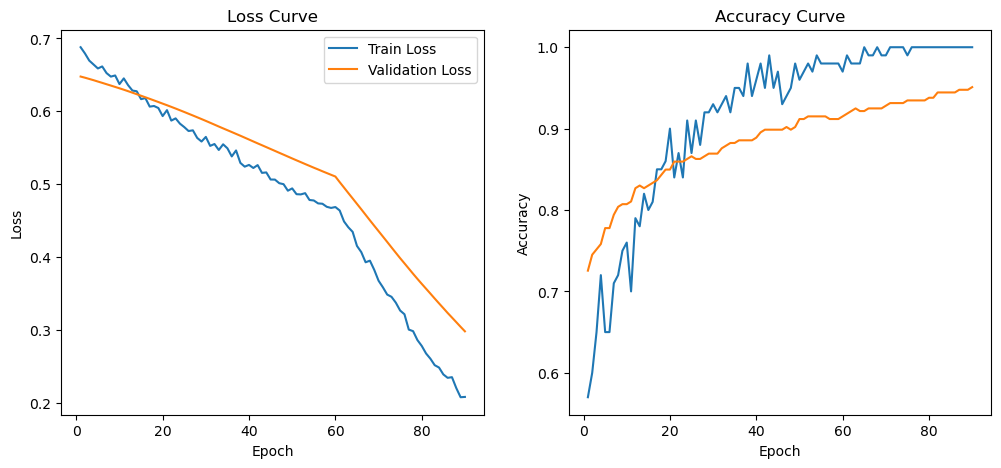

In [24]:
model, train_loss, train_acc, val_loss, val_acc, epochs = train_model(model, criterion, optimizer, 
                                                                      train_loader, val_loader,
                                                                      num_epochs= 30)
# Append metrics to the tracking lists
train_losses.extend(train_loss)
val_losses.extend(val_loss)
train_accuracies.extend(train_acc)
val_accuracies.extend(val_acc)
# Plot after initial training
plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

Just to see where overfitting will take place , lets train the model for 20 more epochs and see the results.

Epoch 1/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Saving new best model with validation accuracy: 0.9510
Epoch [1/20], Loss: 0.1975, Accuracy: 1.0000, Validation Loss: 0.2921, Validation Accuracy: 0.9510


Epoch 2/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [2/20], Loss: 0.1892, Accuracy: 1.0000, Validation Loss: 0.2863, Validation Accuracy: 0.9510


Epoch 3/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [3/20], Loss: 0.1792, Accuracy: 1.0000, Validation Loss: 0.2808, Validation Accuracy: 0.9510


Epoch 4/20 [Training]:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f01e3b372e0>
Traceback (most recent call last):
  File "/home/arsalan/miniconda3/envs/pytorch_opencv/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Epoch 4/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [4/20], Loss: 0.1790, Accuracy: 1.0000, Validation Loss: 0.2753, Validation Accuracy: 0.9510


Epoch 5/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch [5/20], Loss: 0.1716, Accuracy: 1.0000, Validation Loss: 0.2699, Validation Accuracy: 0.9510


Epoch 6/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Saving new best model with validation accuracy: 0.9542
Epoch [6/20], Loss: 0.1662, Accuracy: 1.0000, Validation Loss: 0.2646, Validation Accuracy: 0.9542


Epoch 7/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [7/20], Loss: 0.1567, Accuracy: 1.0000, Validation Loss: 0.2592, Validation Accuracy: 0.9542


Epoch 8/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [8/20], Loss: 0.1560, Accuracy: 1.0000, Validation Loss: 0.2539, Validation Accuracy: 0.9542


Epoch 9/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [9/20], Loss: 0.1441, Accuracy: 1.0000, Validation Loss: 0.2489, Validation Accuracy: 0.9542


Epoch 10/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [10/20], Loss: 0.1436, Accuracy: 1.0000, Validation Loss: 0.2442, Validation Accuracy: 0.9542


Epoch 11/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [11/20], Loss: 0.1367, Accuracy: 1.0000, Validation Loss: 0.2394, Validation Accuracy: 0.9542


Epoch 12/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [12/20], Loss: 0.1462, Accuracy: 1.0000, Validation Loss: 0.2349, Validation Accuracy: 0.9542


Epoch 13/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [13/20], Loss: 0.1330, Accuracy: 1.0000, Validation Loss: 0.2304, Validation Accuracy: 0.9542


Epoch 14/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch [14/20], Loss: 0.1188, Accuracy: 1.0000, Validation Loss: 0.2259, Validation Accuracy: 0.9542


Epoch 15/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Saving new best model with validation accuracy: 0.9575
Epoch [15/20], Loss: 0.1353, Accuracy: 1.0000, Validation Loss: 0.2216, Validation Accuracy: 0.9575


Epoch 16/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [16/20], Loss: 0.1087, Accuracy: 1.0000, Validation Loss: 0.2172, Validation Accuracy: 0.9575


Epoch 17/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [17/20], Loss: 0.1110, Accuracy: 1.0000, Validation Loss: 0.2130, Validation Accuracy: 0.9575


Epoch 18/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [18/20], Loss: 0.1037, Accuracy: 1.0000, Validation Loss: 0.2089, Validation Accuracy: 0.9575


Epoch 19/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [19/20], Loss: 0.1068, Accuracy: 1.0000, Validation Loss: 0.2052, Validation Accuracy: 0.9575


Epoch 20/20 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [20/20], Loss: 0.0986, Accuracy: 1.0000, Validation Loss: 0.2014, Validation Accuracy: 0.9575


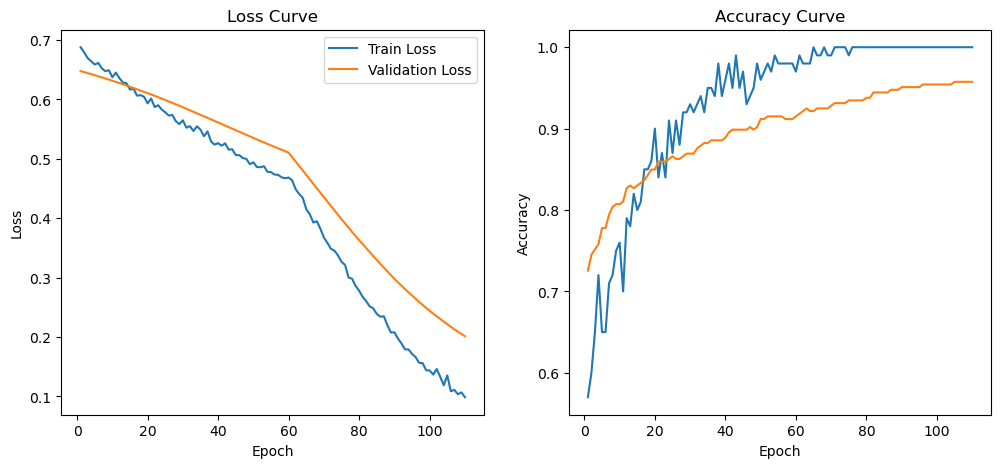

In [25]:
model, train_loss, train_acc, val_loss, val_acc, epochs = train_model(model, criterion, optimizer, 
                                                                      train_loader, val_loader,
                                                                      num_epochs= 20)
# Append metrics to the tracking lists
train_losses.extend(train_loss)
val_losses.extend(val_loss)
train_accuracies.extend(train_acc)
val_accuracies.extend(val_acc)
# Plot after initial training
plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

Above we cas see that model has 10% differences between training loss and validation loss. Lets check the classification report, f1_score, accuracy_score, precision_score, recall_score before we train the model further.

### Confusion Matrix classification_report, f1_score, accuracy_score, precision_score, recall_score

Evaluating on Test Data: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Test Accuracy: 1.0000
Test Loss: 0.0881
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00        50
 WithoutMask       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



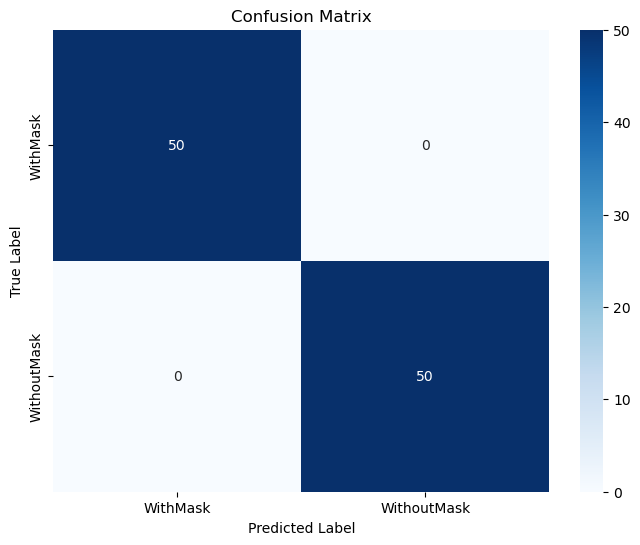

In [26]:

# Function to evaluate the model and calculate additional metrics
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    test_loss = 0.0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Data"):
            inputs, labels = inputs.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]
            
            # Get model outputs (logits)
            outputs = model(inputs)
            if isinstance(outputs, torch.Tensor):
                logits = outputs
            else:
                logits = outputs.logits

            # Calculate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item() * inputs.size(0)  # Accumulate loss over the test set
            total += labels.size(0)
            
            # Convert logits to binary predictions (threshold 0)
            predicted = (logits > 0.0).float()

            # Collect true and predicted labels for further metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate average test loss
    test_loss /= total

    # Flatten the lists for metric calculations
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    
    # F1-score, Precision, Recall for binary classification
    f1 = f1_score(y_true, y_pred)  # By default, for binary classification
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    
    # Classification Report (Detailed metrics for each class)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['WithMask', 'WithoutMask']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['WithMask', 'WithoutMask'], yticklabels=['WithMask', 'WithoutMask'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example of how to call the evaluate_model function
# Pass your trained model, test_loader, and criterion used during training
evaluate_model(model, test_loader, criterion)


As our dataset is relatively small, the model has achieved an accuracy of 100% on the test set. The F1 score, precision, and recall are also quite high, indicating that the model is almost likely to be correct for all tests in the dataset.

Epoch 1/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Saving new best model with validation accuracy: 0.9575
Epoch [1/50], Loss: 0.0938, Accuracy: 1.0000, Validation Loss: 0.1979, Validation Accuracy: 0.9575


Epoch 2/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [2/50], Loss: 0.0861, Accuracy: 1.0000, Validation Loss: 0.1945, Validation Accuracy: 0.9575


Epoch 3/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch [3/50], Loss: 0.0822, Accuracy: 1.0000, Validation Loss: 0.1912, Validation Accuracy: 0.9575


Epoch 4/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch [4/50], Loss: 0.0814, Accuracy: 1.0000, Validation Loss: 0.1883, Validation Accuracy: 0.9575


Epoch 5/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [5/50], Loss: 0.0786, Accuracy: 1.0000, Validation Loss: 0.1853, Validation Accuracy: 0.9575


Epoch 6/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [6/50], Loss: 0.0869, Accuracy: 1.0000, Validation Loss: 0.1823, Validation Accuracy: 0.9575


Epoch 7/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [7/50], Loss: 0.0692, Accuracy: 1.0000, Validation Loss: 0.1795, Validation Accuracy: 0.9575


Epoch 8/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch [8/50], Loss: 0.0767, Accuracy: 1.0000, Validation Loss: 0.1769, Validation Accuracy: 0.9575


Epoch 9/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [9/50], Loss: 0.0692, Accuracy: 1.0000, Validation Loss: 0.1742, Validation Accuracy: 0.9575


Epoch 10/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch [10/50], Loss: 0.0638, Accuracy: 1.0000, Validation Loss: 0.1717, Validation Accuracy: 0.9575


Epoch 11/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [11/50], Loss: 0.0613, Accuracy: 1.0000, Validation Loss: 0.1693, Validation Accuracy: 0.9575


Epoch 12/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [12/50], Loss: 0.0596, Accuracy: 1.0000, Validation Loss: 0.1671, Validation Accuracy: 0.9575


Epoch 13/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [13/50], Loss: 0.0577, Accuracy: 1.0000, Validation Loss: 0.1649, Validation Accuracy: 0.9575


Epoch 14/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [14/50], Loss: 0.0695, Accuracy: 1.0000, Validation Loss: 0.1628, Validation Accuracy: 0.9575


Epoch 15/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [15/50], Loss: 0.0522, Accuracy: 1.0000, Validation Loss: 0.1604, Validation Accuracy: 0.9575


Epoch 16/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [16/50], Loss: 0.0530, Accuracy: 1.0000, Validation Loss: 0.1582, Validation Accuracy: 0.9575


Epoch 17/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [17/50], Loss: 0.0503, Accuracy: 1.0000, Validation Loss: 0.1559, Validation Accuracy: 0.9575


Epoch 18/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [18/50], Loss: 0.0493, Accuracy: 1.0000, Validation Loss: 0.1538, Validation Accuracy: 0.9575


Epoch 19/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Saving new best model with validation accuracy: 0.9608
Epoch [19/50], Loss: 0.0440, Accuracy: 1.0000, Validation Loss: 0.1517, Validation Accuracy: 0.9608


Epoch 20/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch [20/50], Loss: 0.0447, Accuracy: 1.0000, Validation Loss: 0.1497, Validation Accuracy: 0.9608


Epoch 21/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [21/50], Loss: 0.0510, Accuracy: 1.0000, Validation Loss: 0.1480, Validation Accuracy: 0.9608


Epoch 22/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch [22/50], Loss: 0.0403, Accuracy: 1.0000, Validation Loss: 0.1459, Validation Accuracy: 0.9608


Epoch 23/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [23/50], Loss: 0.0410, Accuracy: 1.0000, Validation Loss: 0.1440, Validation Accuracy: 0.9608


Epoch 24/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [24/50], Loss: 0.0370, Accuracy: 1.0000, Validation Loss: 0.1423, Validation Accuracy: 0.9608


Epoch 25/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [25/50], Loss: 0.0364, Accuracy: 1.0000, Validation Loss: 0.1406, Validation Accuracy: 0.9608


Epoch 26/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Saving new best model with validation accuracy: 0.9641
Epoch [26/50], Loss: 0.0341, Accuracy: 1.0000, Validation Loss: 0.1391, Validation Accuracy: 0.9641


Epoch 27/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [27/50], Loss: 0.0685, Accuracy: 1.0000, Validation Loss: 0.1372, Validation Accuracy: 0.9641


Epoch 28/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [28/50], Loss: 0.0363, Accuracy: 1.0000, Validation Loss: 0.1359, Validation Accuracy: 0.9641


Epoch 29/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [29/50], Loss: 0.0333, Accuracy: 1.0000, Validation Loss: 0.1347, Validation Accuracy: 0.9641


Epoch 30/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [30/50], Loss: 0.0344, Accuracy: 1.0000, Validation Loss: 0.1336, Validation Accuracy: 0.9641


Epoch 31/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [31/50], Loss: 0.0305, Accuracy: 1.0000, Validation Loss: 0.1324, Validation Accuracy: 0.9641


Epoch 32/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch [32/50], Loss: 0.0281, Accuracy: 1.0000, Validation Loss: 0.1312, Validation Accuracy: 0.9641


Epoch 33/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch [33/50], Loss: 0.0310, Accuracy: 1.0000, Validation Loss: 0.1298, Validation Accuracy: 0.9641


Epoch 34/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [34/50], Loss: 0.0372, Accuracy: 1.0000, Validation Loss: 0.1290, Validation Accuracy: 0.9641


Epoch 35/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [35/50], Loss: 0.0262, Accuracy: 1.0000, Validation Loss: 0.1277, Validation Accuracy: 0.9641


Epoch 36/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [36/50], Loss: 0.0252, Accuracy: 1.0000, Validation Loss: 0.1265, Validation Accuracy: 0.9641


Epoch 37/50 [Validation]: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch [37/50], Loss: 0.0233, Accuracy: 1.0000, Validation Loss: 0.1252, Validation Accuracy: 0.9641


Epoch 38/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [38/50], Loss: 0.0292, Accuracy: 1.0000, Validation Loss: 0.1242, Validation Accuracy: 0.9641


Epoch 39/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [39/50], Loss: 0.0245, Accuracy: 1.0000, Validation Loss: 0.1228, Validation Accuracy: 0.9641


Epoch 40/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [40/50], Loss: 0.0212, Accuracy: 1.0000, Validation Loss: 0.1217, Validation Accuracy: 0.9641


Epoch 41/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [41/50], Loss: 0.0228, Accuracy: 1.0000, Validation Loss: 0.1206, Validation Accuracy: 0.9641


Epoch 42/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [42/50], Loss: 0.0200, Accuracy: 1.0000, Validation Loss: 0.1195, Validation Accuracy: 0.9641


Epoch 43/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [43/50], Loss: 0.0223, Accuracy: 1.0000, Validation Loss: 0.1184, Validation Accuracy: 0.9641


Epoch 44/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [44/50], Loss: 0.0189, Accuracy: 1.0000, Validation Loss: 0.1172, Validation Accuracy: 0.9641


Epoch 45/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [45/50], Loss: 0.0201, Accuracy: 1.0000, Validation Loss: 0.1160, Validation Accuracy: 0.9641


Epoch 46/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [46/50], Loss: 0.0167, Accuracy: 1.0000, Validation Loss: 0.1149, Validation Accuracy: 0.9641


Epoch 47/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [47/50], Loss: 0.0204, Accuracy: 1.0000, Validation Loss: 0.1140, Validation Accuracy: 0.9641


Epoch 48/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch [48/50], Loss: 0.0183, Accuracy: 1.0000, Validation Loss: 0.1129, Validation Accuracy: 0.9641


Epoch 49/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [49/50], Loss: 0.0167, Accuracy: 1.0000, Validation Loss: 0.1120, Validation Accuracy: 0.9641


Epoch 50/50 [Validation]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [50/50], Loss: 0.0175, Accuracy: 1.0000, Validation Loss: 0.1112, Validation Accuracy: 0.9641


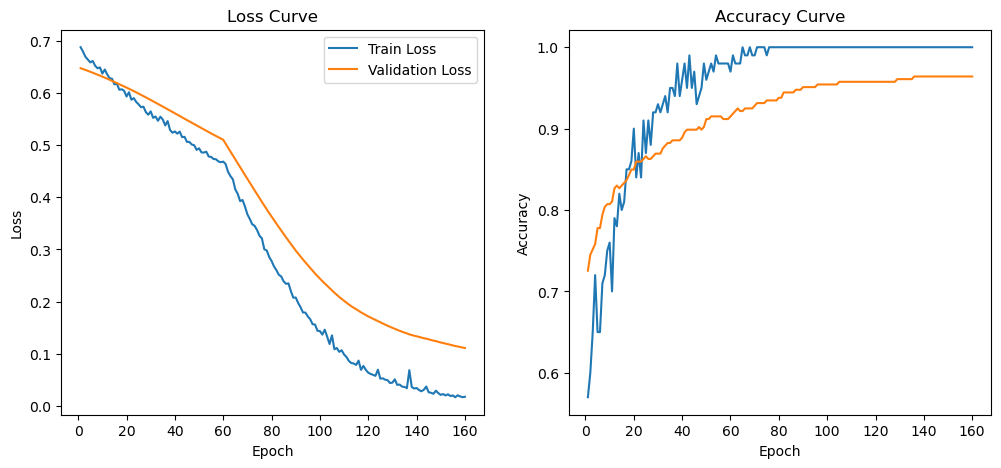

In [27]:
model, train_loss, train_acc, val_loss, val_acc, epochs = train_model(model, criterion, optimizer, 
                                                                      train_loader, val_loader,
                                                                      num_epochs= 50)
# Append metrics to the tracking lists
train_losses.extend(train_loss)
val_losses.extend(val_loss)
train_accuracies.extend(train_acc)
val_accuracies.extend(val_acc)
# Plot after initial training
plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

We can see that model has now reached at at point where training loss and validation loss have both reduced and validation accuracy has increased but also reached a plateau. This indicates that the model has reached its optimal performance and there is no significant improvement even if we train it for more epochs. Other techniques like re-sampling, data augmentation, or using a more complex model could potentially help improve the model's performance.or we can also unfreeze some more layers and train it for more epochs.

Evaluating on Test Data: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Test Accuracy: 1.0000
Test Loss: 0.0150
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00        50
 WithoutMask       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



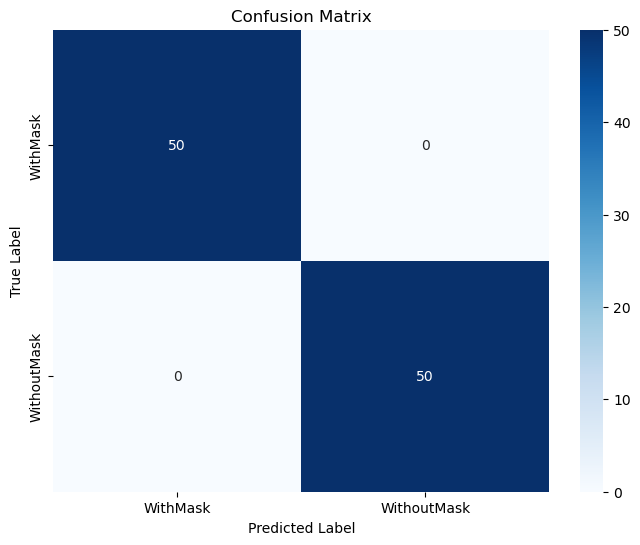

In [28]:
evaluate_model(model, test_loader, criterion)